# Time series forecasting: COVID-19 cases in Skåne

### What is time series forecasting?
We will use time data to forecast (predict) upcoming COVID-19 cases for the Skåne region in Sweden.

### **Dataset**
Number of COVID-19 cases in Sweden per day and region. The dataset is from [Sveriges dataportal](https://www.dataportal.se/sv) and can be found [here](https://www.dataportal.se/sv/datasets/525_1424/antal-fall-av-covid-19-i-sverige-per-dag-och-region).

### What time frames are we looking at?
* Short term: Week
* Medium term: Few months
* Long term: Yearss


In [446]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [447]:
# Import data
#data = 'covid-cases.csv'
data = 'covid19.csv'
df = pd.read_csv(data)

# Lock Skåne column
skåne = df.iloc[:, 12:13]

# Lock date column
datum = df.iloc[:, -1:]

# Merge dataframes
df_covid = pd.merge(skåne, datum, left_index=True, right_index=True)
df_covid.head()

# Rename column Statistikdatum to Datum
df_covid.rename(columns={'Statistikdatum': 'Datum'}, inplace=True)

# Drop all zero values in the dataframe
df_covid = df_covid[(df_covid != 0).all(1)]

In [448]:
# Reverse order of dataframe
df_covid = df_covid.iloc[::-1]
df_covid.head()

,Skåne,Datum
274,1,02/03/2020
273,1,03/03/2020
272,7,04/03/2020
270,8,06/03/2020
269,5,07/03/2020


In [449]:
# Prepare dataframe
df_covid = pd.Series( df_covid['Skåne'].values, 
                    index=pd.DatetimeIndex(data= (tuple(pd.date_range('2020-03-02', periods=272, freq='D'))),
                                          freq='D'))

In [450]:
df_covid.head()

2020-03-02    1
2020-03-03    1
2020-03-04    7
2020-03-05    8
2020-03-06    5
Freq: D, dtype: int64

In [451]:
type(df_covid.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [452]:
# Check type of datum
#print("Datum data type: ", type(df_covid['Datum'][0]))

# Convert column Datum from string to datetime
#df_covid['Datum'] = pd.to_datetime(df_covid['Datum'], infer_datetime_format=True)

# Check type of datum
#print("Datum data type after converting: ", type(df_covid['Datum'][0]))

In [453]:
# Set date as the index of the dataframe
#df_covid = df_covid.set_index(['Datum'])

In [454]:
#df_covid = df_covid.iloc[::-1]

# Visualization and data exploration

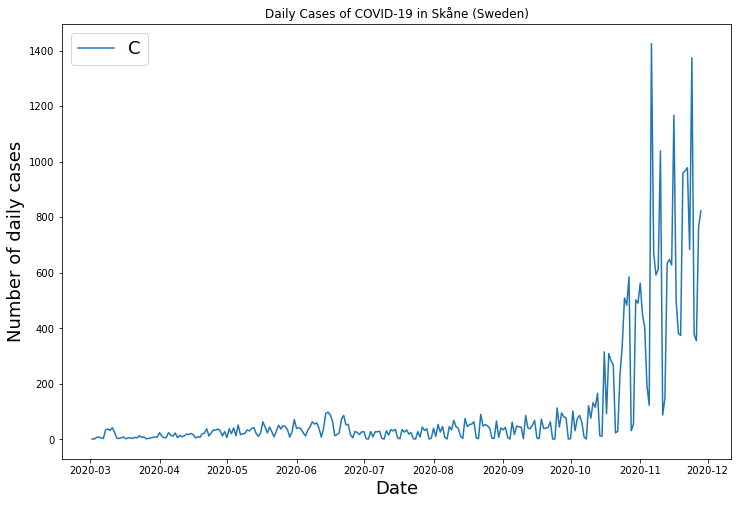

In [455]:
plt.figure(figsize=(12,8))
plt.plot(df_covid)
plt.title('Daily Cases of COVID-19 in Skåne (Sweden)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of daily cases', fontsize=18)
plt.legend('C', fontsize=18);

## Cumulative sums
The total sum of data as it grows with time.

In [456]:
# We need to reverse the dataframe to get the total sum counting from the first case
#reversed_df = df_covid.iloc[::-1]

In [457]:
# Save as a new dataframe
covid_cumulative = np.cumsum(df_covid)

In [458]:
# Last entries
covid_cumulative.tail()

2020-11-24    27261
2020-11-25    27638
2020-11-26    27993
2020-11-27    28758
2020-11-28    29581
Freq: D, dtype: int64

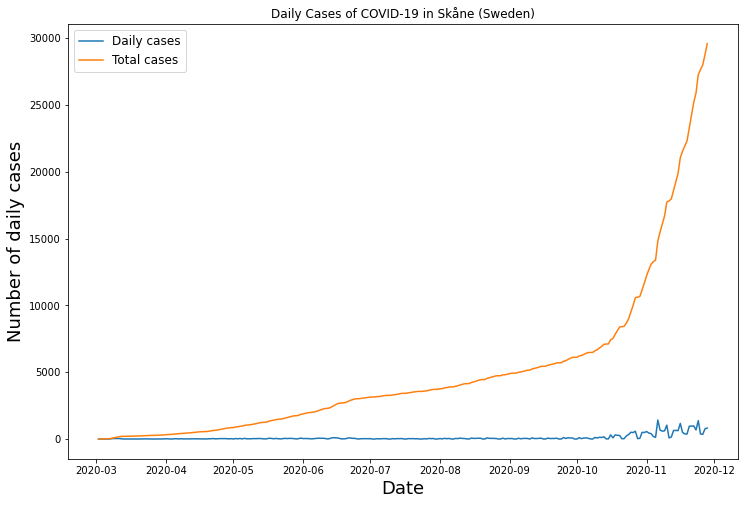

In [459]:
# Plot time series with cumulative
plt.figure(figsize=(12,8))
plt.plot(df_covid)
plt.plot(covid_cumulative)
plt.title('Daily Cases of COVID-19 in Skåne (Sweden)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of daily cases', fontsize=18)
plt.legend(['Daily cases', 'Total cases'], fontsize=12);

# Stationary vs non-stationary
* **Seasonality**: Variations that occur at specific regular intervals 
* **Trend**: Tendency of the data to increase or decrease during a longer period of time
* **Stationary**: No trends or seasonality, easier to model around
* **Non-stationary**: If there is seasonality or a trend to the time series it is non-stationary.
<br><br>
Let us test the dataset for stationarity.

## The Augmented Dickey-Fuller test 
* Statistical test called a unit root test
* Determines how strongly a time series is defined by a trend
* The p-value should be less than the significance level (say 0.05) in order for the time series to be stationary.

In [494]:
from statsmodels.tsa.stattools import adfuller

In [506]:
def stationarity_test(df):
    
    result=adfuller(df, autolag='AIC')
    output = pd.Series(result[0:1], index=['P-value'])
    
    if result[1] <= 0.05:
        print('---Dataset is stationary---')
        print(output)
        
    elif result[1] >= 0.05:
        print('---Dataset is non-stationary---')
        print(output)
    
    

In [509]:
stationarity_test(df_covid)

---Dataset is non-stationary---
P-value    2.730175
dtype: float64


As out data is non-stationary we can go on and difference it.

# Differencing
*Compute the difference of consecutive terms in the series*
<br>
Since our data is non-stationary we need to prepare it and difference it to make it stationary. <br>
Using the ARIMA model we can also difference our data when we fit the model, which we will use later. <br>
This is just showing the intuition of differencing.

## Before differencing

In [462]:
#pip install pmdarima

In [463]:
from pmdarima.arima import ndiffs

In [464]:
# Make a copy of the dataframe
df_differencing = df_covid.copy()

In [465]:
# Helper function differencing estimation

def differencing_estimation(df):
    
    # Check for estimated differencing term
    kpss_diffs = ndiffs(df, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(df, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)
    
    return n_diffs

Estimated differencing.

In [467]:
differencing_estimation(df_differencing)

1

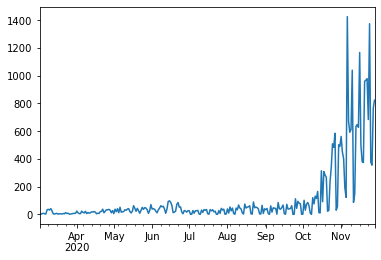

In [468]:
df_differencing.plot();

## After differencing

In [469]:
df_differencing = df_differencing.diff().dropna()
stationarity_test(df_differencing)

---Dataset is stationary---
P-value   -3.020939
dtype: float64


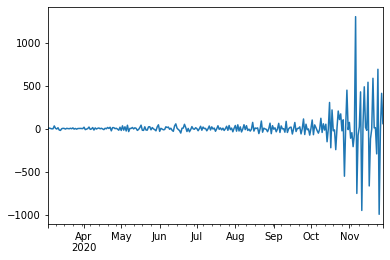

In [470]:
df_differencing.plot();

In [471]:
differencing_estimation(df_differencing)

0

## Autocorrelation
* Similarity between observations as a function of the time
* Correlation within the data on a time scale
<br><br>

We will test for autocorrelation in our data. <br>
If the plots are outside of the blue area it shows correlation in the data.

In [472]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [473]:
# Helper function autocorrelation
def auto_corr(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    plot_acf(df, lags=7, ax=ax1)
    plot_pacf(df, lags=7, ax=ax2);

### Autocorrelation without differencing

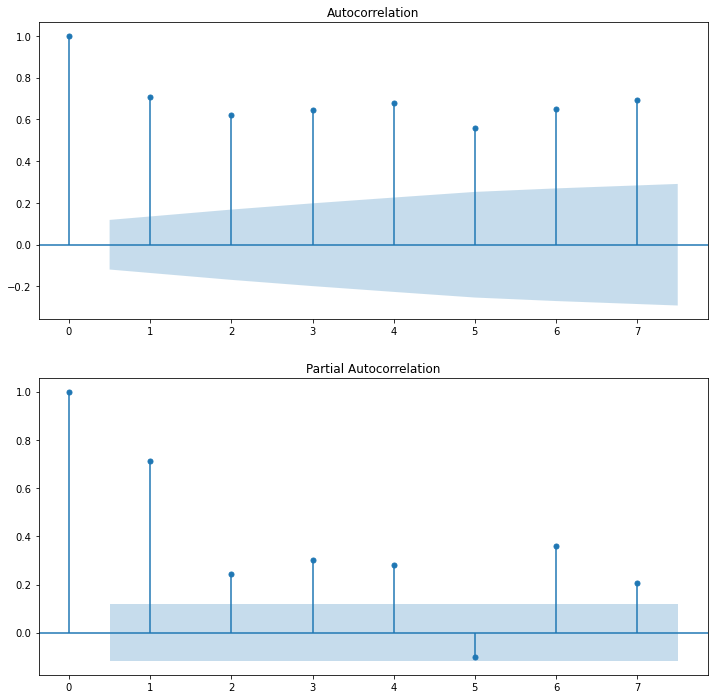

In [474]:
auto_corr(df_covid)

### Autocorrelation with differencing

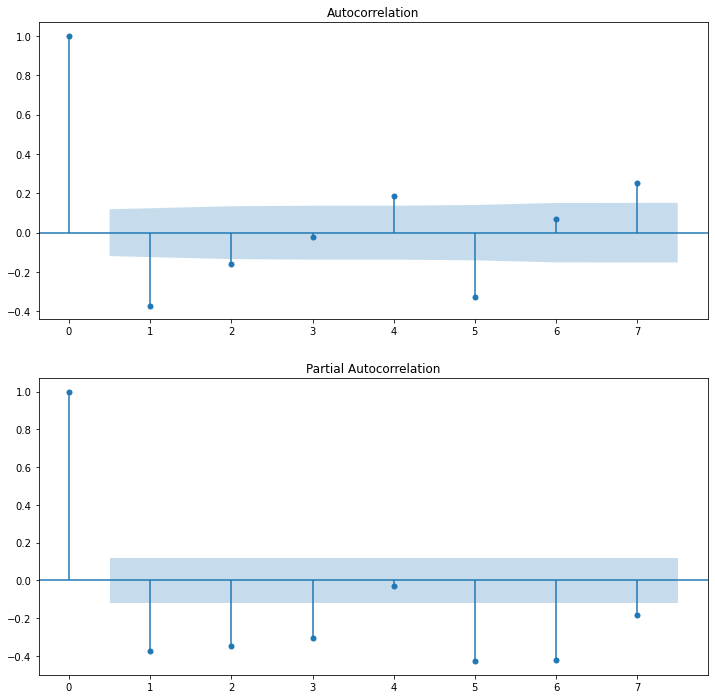

In [475]:
auto_corr(df_differencing)

## ARIMA Model

* **p**: Order of autoregression (AR)
* **d**: Grade of differencing
* **q**: Order of moving average (MA)
* Arima can only be used on a stationary dataset, as we have done differencing above our data is now stationary.

## Find best p, q and d values
We can install [pmdarima](http://alkaline-ml.com/pmdarima/index.html) and get an automated help with choosing our values for p,d and q. <br>
We can also have a look at our autocorrelation and choose the AR and MA values from there, but below there is an automated way of getting the best solution. This saves time as we don't have to try different values and see how well our model is fitted to our data.

In [476]:
#pip install pmdarima

In [477]:
import pmdarima as pm

In [514]:
# Helper function aic
def best_model(df, differencing):
    auto = pm.auto_arima(df, d=differencing, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=None,
                     max_order=None, trace=True)
    
    return auto

### Best model without differencing

In [515]:
no_diff_df = differencing_estimation(df_covid)
best_model(df_covid, no_diff_df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3379.261, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3546.831, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3508.990, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3421.269, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3544.920, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3422.296, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3415.114, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3402.081, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3422.177, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3416.319, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3414.037, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3380.520, Time=0.43 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] interc

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

### Best model with differencing

In [516]:
diff_df = differencing_estimation(df_differencing)
best_model(df_differencing, diff_df)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3380.530, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3544.920, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3507.181, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3423.166, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3424.188, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3417.174, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3404.021, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3388.054, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3424.055, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3380.260, Time=0.40 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3417.140, Time=0.11 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3423.436, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=3389.215, Time=0.30 sec
 ARIMA(2,0,4)(0,0,0)[0]             : 

ARIMA(order=(2, 0, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Above we have the best solutions for our ARIMA models

### Without differencing
* p (AR) = 2
* d (differencing) = 1
* q (MA) = 2

### With differencing
* p (AR) = 2
* d (differencing) = 0
* q (MA) = 5

# Comparing models, differencing and no differencing

In [614]:
from statsmodels.tsa.arima_model import ARIMA

In [615]:
# Helper function ARIMA model and plotting
def arima_model(df, p, d, q):
    model=ARIMA(df, order=(p,d,q))
    result = model.fit()
    
    return result

In [616]:
# Heper function plot model
def plot_model(df, model):
    # Plot and see how well the values are fitted
    plt.figure(figsize=(12,8))
    plt.plot(df_covid)
    plt.plot(model.fittedvalues, color='red');

### Without differencing model

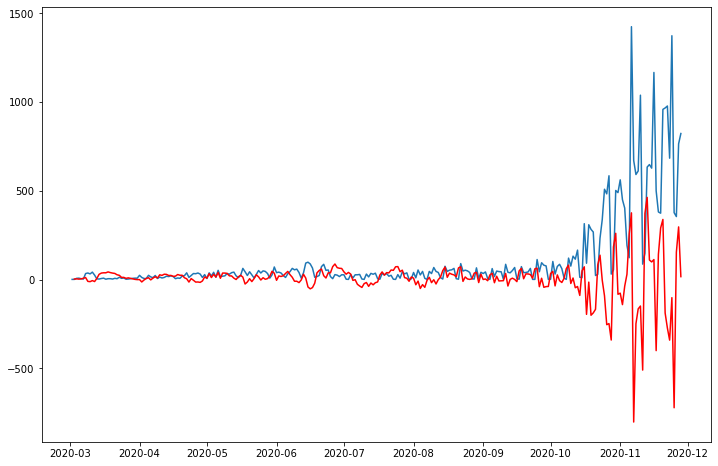

In [617]:
model = arima_model(df_covid, 2, 1, 2)
plot = plot_model(df_covid, model)

### With differencing model

C:\Users\Helena\Anaconda3\envs\pysyft\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


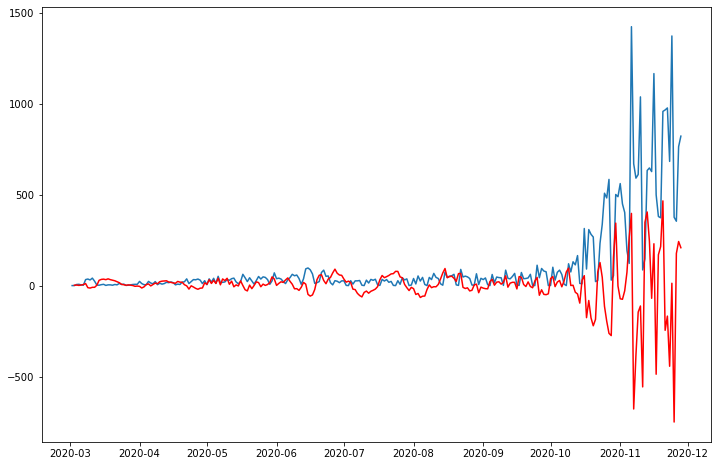

In [618]:
model_diff = arima_model(df_differencing, 2, 0, 5)
plot_diff = plot_model(df_differencing, model_diff)

The model does not do a good job with fitting the values. <br>
Let us try changing the values from the autocorrelation plots and see if we can improve it.

C:\Users\Helena\Anaconda3\envs\pysyft\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Helena\Anaconda3\envs\pysyft\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


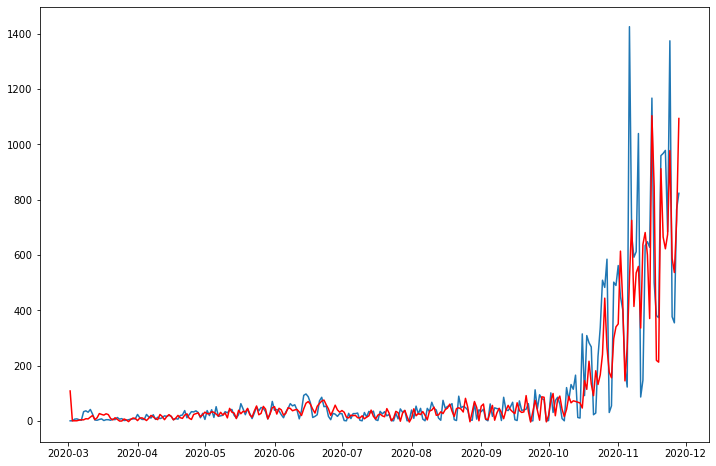

In [619]:
model_tweek = arima_model(df_covid, 6, 0, 5)
plot_tweek = plot_model(df_covid, model_tweek)

# Forecast upcoming 7 days

In [620]:
# Helper function forecasting
def forecasting(model):
    # Forecast upcoming 30 days
    forecast = model.forecast(steps=7)[0]
    df_forecast = pd.DataFrame(forecast, columns=['Forecasted cases'])
    
    # Create dataframe with dates for upcoming 30 days
    date = pd.DataFrame(pd.date_range('2020-12-02', '2020-12-31', 
                     freq='D'), columns=['Date']) 
    
    # Merge dataframes
    forecast_df = pd.merge(date,df_forecast, left_index=True, right_index=True)
    
    return forecast_df

## Without differencing forecast

In [621]:
forecasting(model)

,Date,Forecasted cases
0,2020-12-02,808.786049
1,2020-12-03,821.505954
2,2020-12-04,838.146537
3,2020-12-05,851.913472
4,2020-12-06,861.937818
5,2020-12-07,869.060388
6,2020-12-08,874.307465


## With differencing forecast

In [622]:
forecasting(model_diff)

,Date,Forecasted cases
0,2020-12-02,-176.591397
1,2020-12-03,316.223818
2,2020-12-04,-205.749079
3,2020-12-05,187.490407
4,2020-12-06,-181.205619
5,2020-12-07,183.162031
6,2020-12-08,-175.891440


### Manual tweek

In [623]:
forecasting(model_tweek)

,Date,Forecasted cases
0,2020-12-02,511.852486
1,2020-12-03,953.717776
2,2020-12-04,938.514459
3,2020-12-05,812.201636
4,2020-12-06,419.077849
5,2020-12-07,870.578006
6,2020-12-08,720.240074


# PyTorch

Let us build a small model in PyTorch and compare it to the other models we have created.

In [643]:
import torch
from torch import nn, optim

In [644]:
class CoronaVirusPredictor(nn.Module):
    
    

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred



In [649]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(df_covid)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [650]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=5, 
  n_layers=2
)
model, train_hist, _ = train_model(model, df_covid, df_covid)

TypeError: view() takes from 1 to 2 positional arguments but 4 were given

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [ ]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();